<a href="https://colab.research.google.com/github/IEXE-Tec/aprendizaje-maquina-2/blob/master/01_seleccion_de_variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np

# Graphics
import matplotlib
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# Seleccion Univariada

Para esta seccion utilizaremos el set de datos de penguinos, y trataremos de predecir el Sexo del Pinguino utilizando las demas varaibles -> Y='sex'

Carguemos el set de datos de pinguinos.

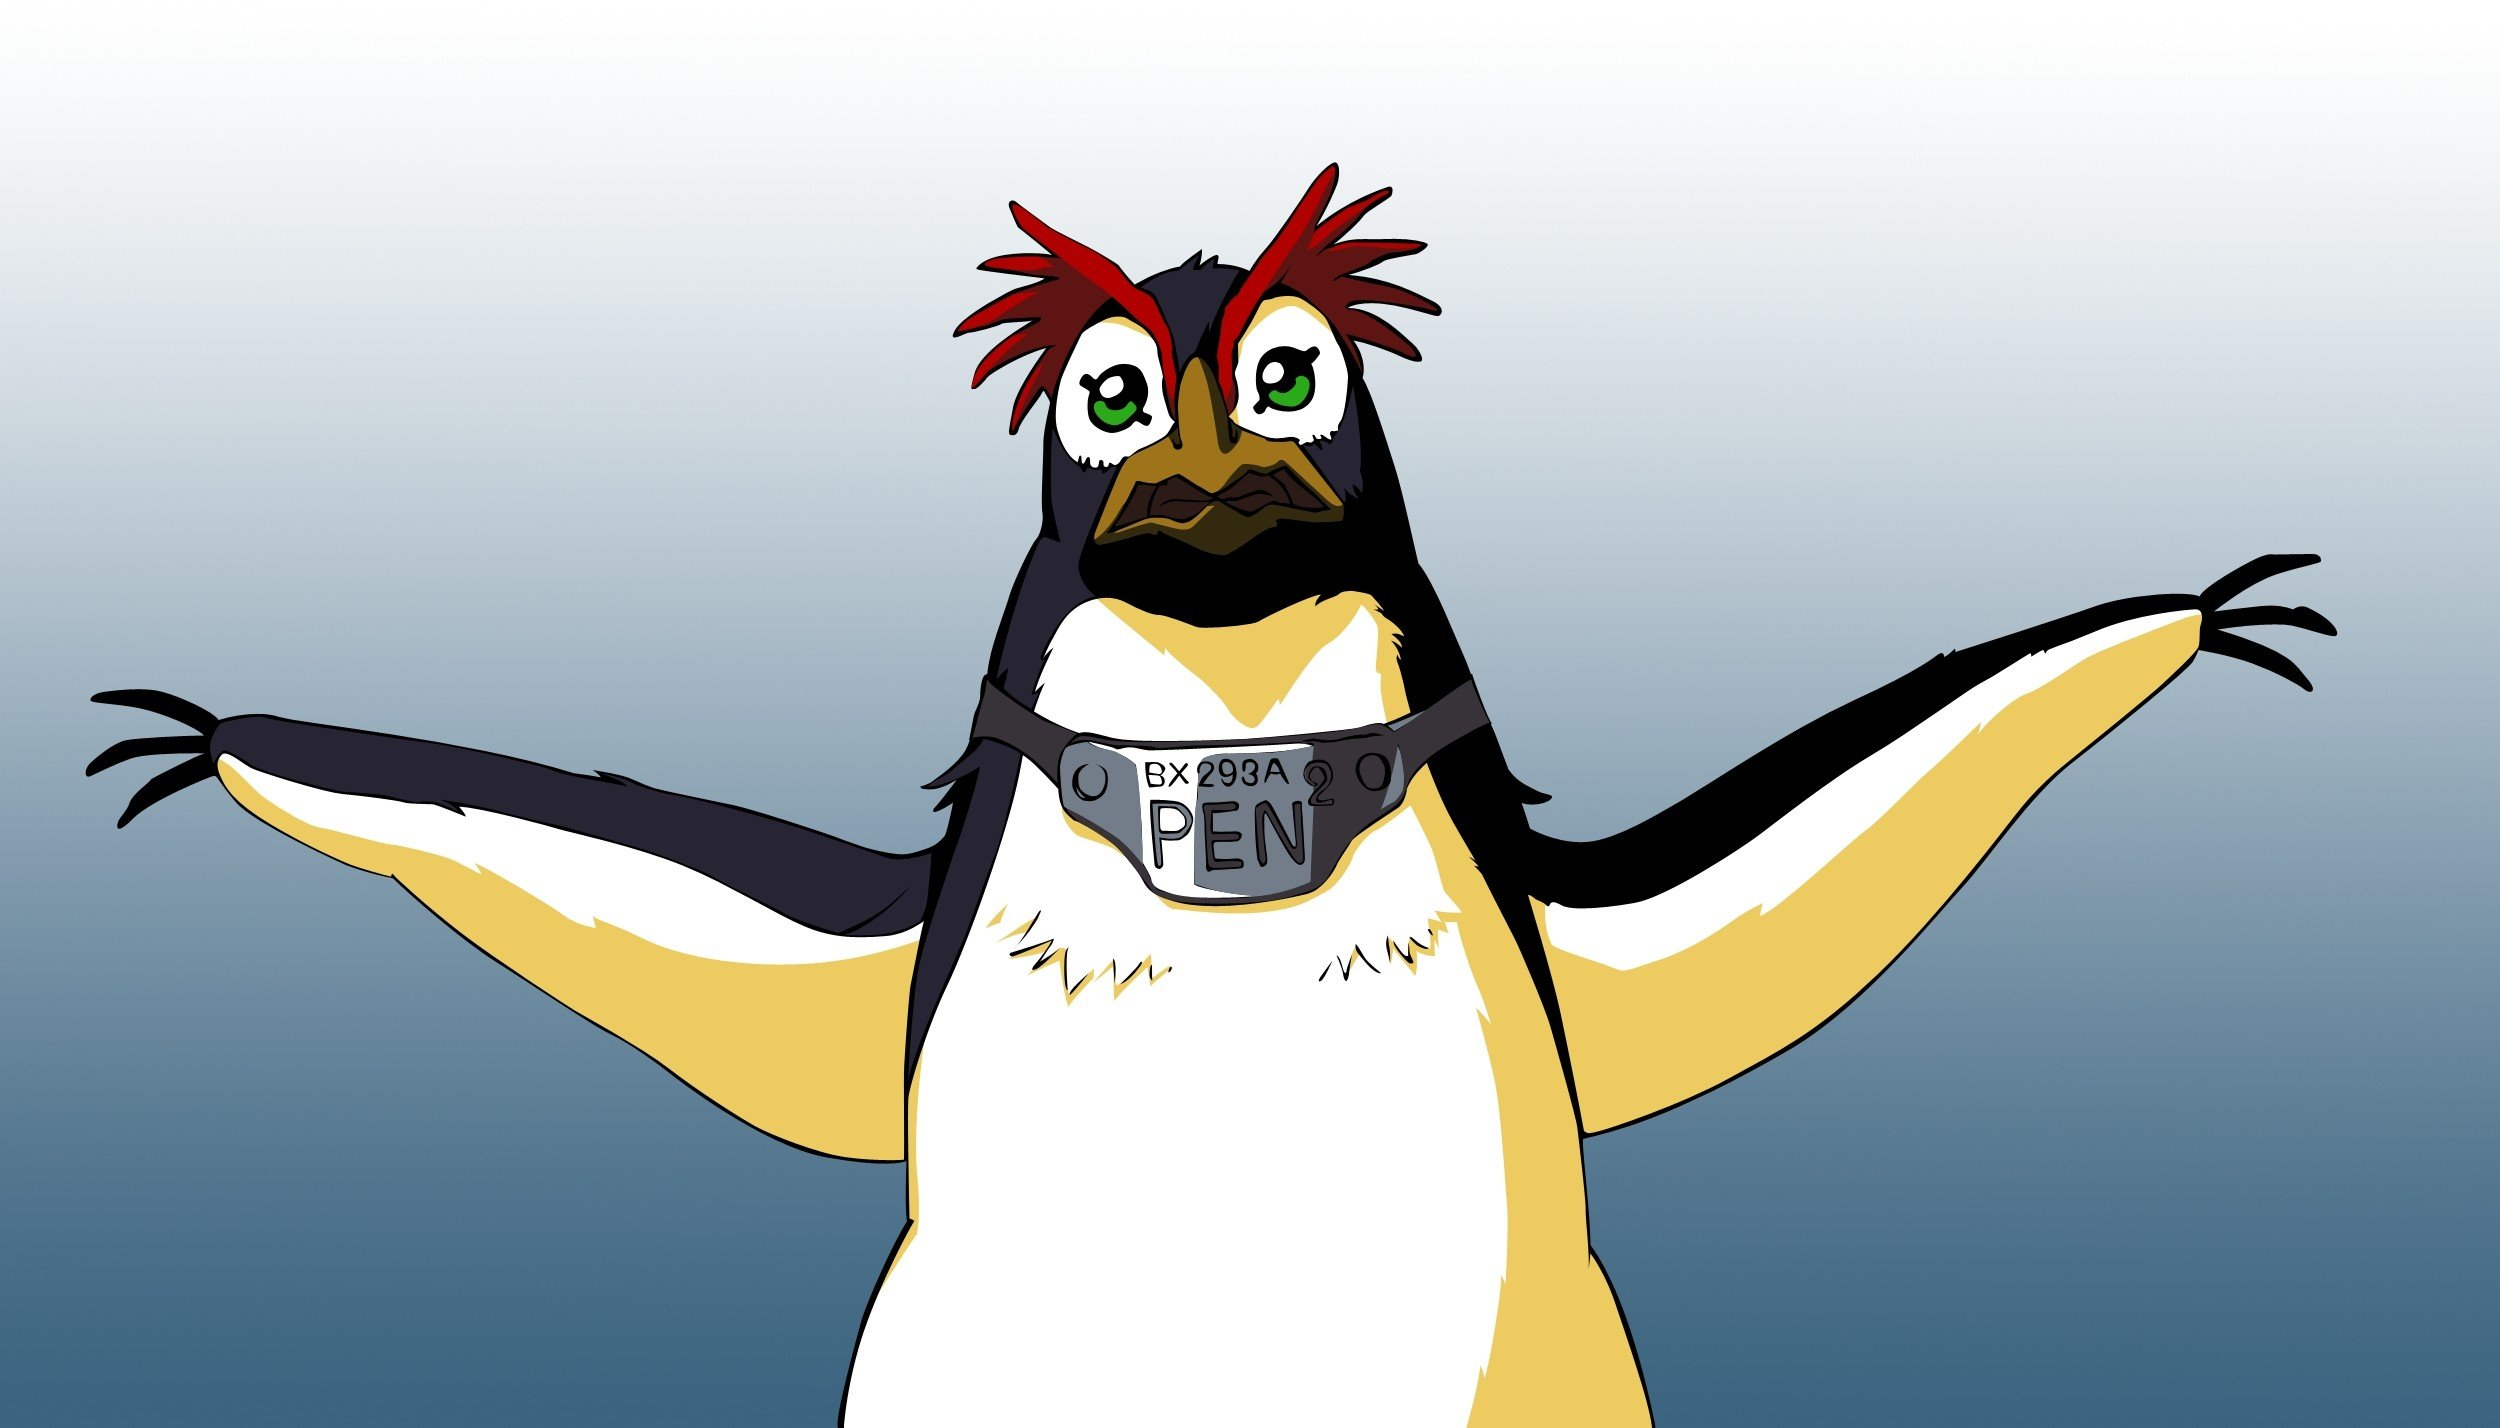

In [27]:
# Load the penguin Dataset
penguins = sns.load_dataset('penguins')
penguins.head()

species     island  bill_length_mm  ...  flipper_length_mm  body_mass_g     sex
0  Adelie  Torgersen            39.1  ...              181.0       3750.0    Male
1  Adelie  Torgersen            39.5  ...              186.0       3800.0  Female
2  Adelie  Torgersen            40.3  ...              195.0       3250.0  Female
3  Adelie  Torgersen             NaN  ...                NaN          NaN     NaN
4  Adelie  Torgersen            36.7  ...              193.0       3450.0  Female

[5 rows x 7 columns]

Eliminemos los missing y nan.
Cambiemos la varaible objetivo a 0 y 1 (Encoding)

In [28]:
# Lets get rid of the nan
penguins.dropna(inplace=True)
# Encode the sex
penguins.replace({'Male':0, 'Female':1}, inplace=True)

Utilicemos el metodo de Pandas get_dummies. (https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

Recuerda utilizar el argumento drop_first=True, de lo contrario se creara una columna para cada valor de la variable lo cual causara problemas de colinealidad.

In [29]:
penguins.head()

species     island  bill_length_mm  ...  flipper_length_mm  body_mass_g  sex
0  Adelie  Torgersen            39.1  ...              181.0       3750.0    0
1  Adelie  Torgersen            39.5  ...              186.0       3800.0    1
2  Adelie  Torgersen            40.3  ...              195.0       3250.0    1
4  Adelie  Torgersen            36.7  ...              193.0       3450.0    1
5  Adelie  Torgersen            39.3  ...              190.0       3650.0    0

[5 rows x 7 columns]

In [30]:
# Encode Species & island
pen = pd.get_dummies(penguins, columns=['species', 'island'], 
                          drop_first=True)
pen.columns

Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g',
       'sex', 'species_Chinstrap', 'species_Gentoo', 'island_Dream',
       'island_Torgersen'],
      dtype='object')

## Analicemos la Varianza

In [31]:
pen.std()/pen.mean()

bill_length_mm       0.124308
bill_depth_mm        0.114725
flipper_length_mm    0.069742
body_mass_g          0.191396
sex                  1.010568
species_Chinstrap    1.977068
species_Gentoo       1.343032
island_Dream         1.308610
island_Torgersen     2.470513
dtype: float64

## Analicemos sus correlaciones

In [32]:
pen.columns

Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g',
       'sex', 'species_Chinstrap', 'species_Gentoo', 'island_Dream',
       'island_Torgersen'],
      dtype='object')

In [33]:
pen[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']].corr()

bill_length_mm  ...  body_mass_g
bill_length_mm           1.000000  ...     0.589451
bill_depth_mm           -0.228626  ...    -0.472016
flipper_length_mm        0.653096  ...     0.872979
body_mass_g              0.589451  ...     1.000000

[4 rows x 4 columns]

Analicemos la matriz de correlaciones con un Heatmap

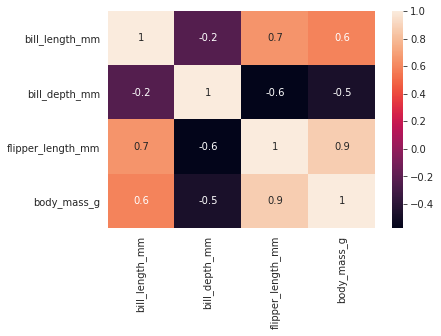

In [34]:

sns.heatmap(pen[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm',
                 'body_mass_g']].corr(), annot = True, fmt='.1g')

## Chi-square

In [35]:
# Importemos chi2 de sklearn
from sklearn.feature_selection import chi2

In [36]:
catv = [c for c in pen.columns if ('island' in c)|('species' in c)]
X = pen[catv]
y = pen['sex']

chi_sq, p_val = chi2(X,y)
chi_values = pd.DataFrame.from_dict({'variable':X.columns,
                        'chi_sq':chi_sq, 'p_value':p_val})
chi_values.sort_values(ascending=True, by='p_value').round(3)


variable  chi_sq  p_value
3   island_Torgersen   0.043    0.836
1     species_Gentoo   0.031    0.860
0  species_Chinstrap   0.006    0.941
2       island_Dream   0.000    0.992

In [37]:
catv = [c for c in penguins.columns if ('island' in c)|('species' in c)]
X = penguins[catv]
y = penguins['sex']
# Encode categorical columns to numbers
X.replace({'Torgersen':0, 'Biscoe':1, 'Dream':2}, inplace=True)
X.replace({'Adelie':0, 'Chinstrap':1, 'Gentoo':2}, inplace=True)
# Independence Test
chi_sq, p_val = chi2(X,y)
chi_values = pd.DataFrame.from_dict({'variable':X.columns,
                        'chi_sq':chi_sq, 'p_value':p_val})
chi_values.sort_values(ascending=True, by='p_value').round(3)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4384: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


variable  chi_sq  p_value
0  species   0.034    0.853
1   island   0.004    0.948

# Predicciones

In [38]:
cat_variables =  ['species_Chinstrap', 'species_Gentoo', 'island_Dream',
       'island_Torgersen']


In [39]:
# Preprocess data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def preprocess_split(X, y,test_size=0.2,random_state=5874,
                        scale_x=True,
                        cat_variables=[], 
                        scale_y=False):

  # Split data
  x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size, 
                                                    random_state=random_state)
  # Scale X
  if scale_x:
    # Find numerical column index
    num_i = [X.columns.get_loc(c) for c in X.columns if c not in cat_variables]
    cat_i = [X.columns.get_loc(c) for c in X.columns if c in cat_variables]
    # Scale Numerical Variables
    x_train_ = x_train.iloc[:, num_i]
    x_test_ = x_test.iloc[:, num_i]
    scaler = StandardScaler().fit(x_train_)
    x_train_ = scaler.transform(x_train_)
    x_test_ = scaler.transform(x_test_)
    # Create new dataframe
    x_train = np.concatenate([x_train_, x_train.iloc[:,cat_i]], axis=1)
    x_test = np.concatenate([x_test_, x_test.iloc[:,cat_i]],axis=1)

  # Scale Y
  if scale_y:
    scaler = StandardScaler().fit(y_train)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)

  return x_train, x_test, y_train, y_test



In [40]:
# Funcion de regresion logistica
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
def log_regression(x_train, x_test, y_train, y_test):
  
  #print(x_train.columns)
  # Train Logistic Model
  model = LogisticRegression()
  model.fit(x_train, y_train)

  #Test the model
  predictions = model.predict(x_test)

  #Check precision, recall, f1-score
  #print( '\n', classification_report(y_test, predictions) )
  print( 'Accuracy: ', accuracy_score(y_test, predictions))
  #print('\n Coefficients: \n', model.coef_)
  print('----------------------------------------------------------------')



In [41]:
# Create data set
X = pen.loc[:, pen.columns!='sex']
y = pen['sex']

x_train, x_test, y_train, y_test = preprocess_split(X, y, scale_x=True, 
                                                    random_state=5874,
                                                  cat_variables =cat_variables, 
                                                    test_size=0.2)
print('X columns: \n',X.columns)
log_regression(x_train, x_test, y_train, y_test)

X columns: 
 Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g',
       'species_Chinstrap', 'species_Gentoo', 'island_Dream',
       'island_Torgersen'],
      dtype='object')
Accuracy:  0.9253731343283582
----------------------------------------------------------------


## Realicemos una seleccion *univariada*

### Correlacion: Variables explicativas

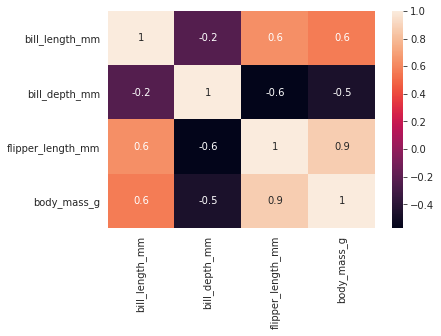

In [42]:
X = pen.loc[:, pen.columns!='sex']
y = pen['sex']


x_train, x_test, y_train, y_test = preprocess_split(X, y, scale_x=True, 
                                                    random_state=5874,
                                                  cat_variables =cat_variables, 
                                                    test_size=0.2)

sns.heatmap( pd.DataFrame(x_train, columns=X.columns)[['bill_length_mm', 
          'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']].corr() , 
          annot = True, fmt='.1g')

Las variables explicativas de largo de aleta y peso estan muy relacionadas. No estaria mal quitar alguna de ellas.

### Chi-square: Variables categoricas y objetivo

In [43]:
X = pen.loc[:, pen.columns!='sex']
y = pen['sex']

x_train, x_test, y_train, y_test = preprocess_split(X, y, scale_x=True, 
                                                    random_state=5874,
                                                  cat_variables =cat_variables, 
                                                    test_size=0.2)
chi_sq, p_val = chi2(pd.DataFrame(x_train, columns=X.columns)[cat_variables],
                     y_train)
chi_values = pd.DataFrame.from_dict({'variable':cat_variables ,
                         'chi_sq':chi_sq, 'p_value':p_val})
chi_values.sort_values(ascending=True, by='p_value').round(3)

variable  chi_sq  p_value
0  species_Chinstrap   0.491    0.484
3   island_Torgersen   0.121    0.728
2       island_Dream   0.045    0.832
1     species_Gentoo   0.017    0.898

In [44]:
sub_set = [c for c in X.columns if ('island' not in c)]
sub_set = [c for c in sub_set if ('species' not in c)]

X = pen[sub_set]
y = pen['sex']

x_train, x_test, y_train, y_test = preprocess_split(X, y, scale_x=True, 
                                                    test_size=0.2, 
                                                    random_state=5874)
print(X.columns)
log_regression(x_train, x_test, y_train, y_test)

Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'], dtype='object')
Accuracy:  0.9253731343283582
----------------------------------------------------------------


### Nuevo modelo

In [45]:
sub_set = [c for c in X.columns if ('island' not in c)]
sub_set = [c for c in sub_set if ('species' not in c)]

X = pen[sub_set]
X = X.drop('flipper_length_mm', axis=1)
y = pen['sex']

x_train, x_test, y_train, y_test = preprocess_split(X, y, scale_x=True, 
                                                    test_size=0.2, 
                                                    random_state=5874)
print(X.columns)
log_regression(x_train, x_test, y_train, y_test)

Index(['bill_length_mm', 'bill_depth_mm', 'body_mass_g'], dtype='object')
Accuracy:  0.9253731343283582
----------------------------------------------------------------


### Correlacion Biseral Puntual

In [53]:
from scipy.stats import pointbiserialr

for c in ['bill_length_mm', 'bill_depth_mm', 
          'flipper_length_mm', 'body_mass_g']:
  pbc = pointbiserialr(pen[c], pen['sex'])
  print(c, ',sex')
  print('Correlation: ', pbc[0])
  print('P-value: ', pbc[1])
  print()

bill_length_mm ,sex
Correlation:  -0.3440777822374857
P-value:  1.0942555387200282e-10

bill_depth_mm ,sex
Correlation:  -0.37267328821677687
P-value:  2.0664103457552388e-12

flipper_length_mm ,sex
Correlation:  -0.2551688758106062
P-value:  2.391097092554368e-06

body_mass_g ,sex
Correlation:  -0.42498699090399544
P-value:  4.897246751596525e-16

